<h1>SVHN Classification using CNNs</h1>

---



# Importing Keras Modules


In [14]:
#Importing important modules
import keras
import tensorflow 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading the Dataset

<h3>Import train and test sets of  SVHN dataset</h3>

In [3]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/gdrive/MyDrive/Colab Notebooks/CNN/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()


<h4>Visualizing the dataset</h4>

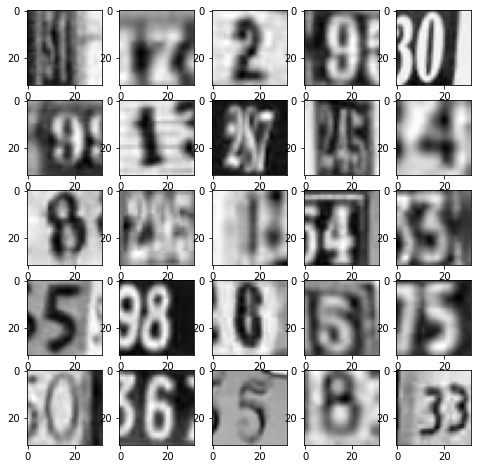

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(0, columns*rows):
    img = x_test[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap='gray')
plt.show()

In [5]:
y_test[:25]

array([1, 7, 2, 9, 0, 9, 1, 8, 4, 4, 8, 9, 1, 4, 3, 5, 8, 6, 5, 5, 0, 6,
       5, 8, 3], dtype=uint8)

In [6]:
x_train.shape

(42000, 32, 32)

In [7]:
#Importing opencv module for the resizing function
import cv2

#Create a resized dataset for training and testing inputs with corresponding size. Here we are resizing it to 28X28 (same input size as MNIST)
x_train_res = np.zeros((x_train.shape[0],28,28), dtype=np.float32)
for i in range(x_train.shape[0]):
  #using cv2.resize to resize each train example to 28X28 size using Cubic interpolation
  x_train_res[i,:,:] = cv2.resize(x_train[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

x_test_res = np.zeros((x_test.shape[0],28,28), dtype=np.float32)
for i in range(x_test.shape[0]):
  #using cv2.resize to resize each test example to 28X28 size using Cubic interpolation
  x_test_res[i,:,:] = cv2.resize(x_test[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
  
#We don't need the original dataset anynmore so we can clear up memory consumed by original dataset
del x_train
del x_test

print(x_train_res.shape)
print(x_test_res.shape)

(42000, 28, 28)
(18000, 28, 28)


<h3>Reshape train and test sets into shapes compatible with keras models</h3>

<h4>Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.</h4>


In [8]:
# input image dimensions
img_rows, img_cols = 28, 28


#Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train_res.reshape(x_train_res.shape[0], img_rows, img_cols, 1)
x_test = x_test_res.reshape(x_test_res.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [9]:
x_train_res.shape

(42000, 28, 28)

<h3>Pre-processing the dataset</h3>
<h4>Normalizing the input</h4>

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255.0
x_test /= 255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 28, 28, 1)
42000 train samples
18000 test samples


In [11]:
batch_size = 128
num_classes = 10
epochs = 12

<h4>Convert Labels from digits to one hot vectors</h4>

In [12]:
# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [13]:
print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Building the CNN 

<h4>Define the layers of model</h4> 

In [15]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation="relu", input_shape=input_shape, padding="same"))

# S2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid"))

# C3 Convolutional Layer
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="valid"))

# S4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

# C5 Fully Connected Convolutional Layer
model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="valid"))
#Flatten the CNN output so that we can connect it with fully connected layers
model.add(Flatten())

# FC6 Fully Connected Layer
model.add(Dense(84, activation="relu"))

#Output Layer with softmax activation
model.add(Dense(10, activation="softmax"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 27, 27, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 11, 11, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 5880)              0

<h4>Set Adam Optimizer and Loss function for training</h4> 

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

#To use adam optimizer for learning weights with learning rate = 0.001
#optimizer = Adam(learning_rate=0.001)
#Set the loss function and optimizer for the model training
model.compile(loss=categorical_crossentropy,
              optimizer='SGD',
              metrics=['accuracy'])

# Training the CNN 

<h4>Initializing Early stopping and Model chekpoint callbacks </h4>

In [21]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('svhn_lenet_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

<h4>Fit the model to the dataset</h4>

In [22]:
#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/12
327/329 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9830
Epoch 1: val_loss improved from inf to 0.79070, saving model to svhn_cnn_checkpoint_01_loss0.7907.h5
329/329 [==============================] - 6s 16ms/step - loss: 0.0587 - accuracy: 0.9830 - val_loss: 0.7907 - val_accuracy: 0.8332
Epoch 2/12
326/329 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9879
Epoch 2: val_loss improved from 0.79070 to 0.55212, saving model to svhn_cnn_checkpoint_02_loss0.5521.h5
329/329 [==============================] - 5s 14ms/step - loss: 0.0476 - accuracy: 0.9880 - val_loss: 0.5521 - val_accuracy: 0.8991
Epoch 3/12
325/329 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9898
Epoch 3: val_loss did not improve from 0.55212
329/329 [==============================] - 5s 14ms/step - loss: 0.0408 - accuracy: 0.9899 - val_loss: 0.5802 - val_accuracy: 0.8994
Epoch 4/12
327/329 [============================>.] - ETA: 0s -

# Evaluating the CNN

<h4>Evaluate trained model on the test set</h4>

In [23]:
#Testing the model on test set
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

563/563 [==============================] - 2s 4ms/step - loss: 0.6884 - accuracy: 0.8985
Test loss: 0.6883559823036194
Test accuracy: 0.8985000252723694


<h4>Visualize 5 test set image predictions</h4> 

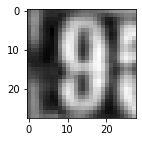

9


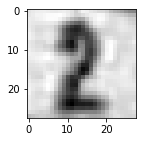

2


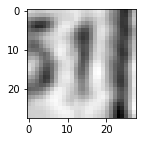

1


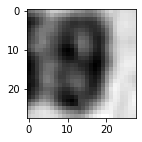

9


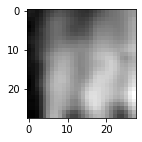

1


In [ ]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(x_test[3].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[3].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[2].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[2].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[33].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[33].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[59].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[59].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[100].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[100].reshape(1,28,28,1))))

# Saving the CNN

<h4>Save the trained weights and model in h5 files</h4> 

In [ ]:
#Set the path where you want to store the model and weights. 
model.save('/content/gdrive/My Drive/Colab Notebooks/CNN/Computer Vision Essentials/cnn_lenet_svhn.h5')
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/CNN/Computer Vision Essentials/cnn_lenet_svhn_weights.h5')